In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [142]:
# Set plot style for professional appearance
plt.style.use('ggplot')

In [143]:
df = pd.read_csv(r"C:\Users\prave\Music\mlml\CAR DETAILS FROM CAR DEKHO.csv")

In [144]:
# --- Feature Engineering ---
current_year = 2025
df['Car_Age'] = current_year - df['year']
df['Car_Brand'] = df['name'].apply(lambda x: x.split(' ')[0])
df.drop(['year', 'name'], axis=1, inplace=True)

In [145]:
# --- Imputation (For Syllabus Compliance) ---
for col in df.columns:
    if df[col].dtype != object:
        df.fillna({col: df[col].median()}, inplace=True)


In [146]:
# --- Target Transformation (Crucial for MLR Baseline) ---
df['Selling_Price_Log'] = np.log1p(df['selling_price'])

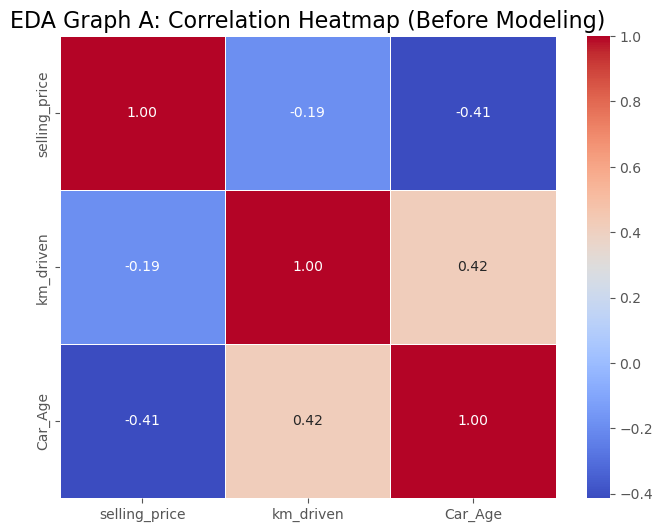

In [147]:
# Graph A: Correlation Heatmap (Before Modeling)
numerical_cols = ['selling_price', 'km_driven', 'Car_Age']
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('EDA Graph A: Correlation Heatmap (Before Modeling)', fontsize=16)
plt.show()

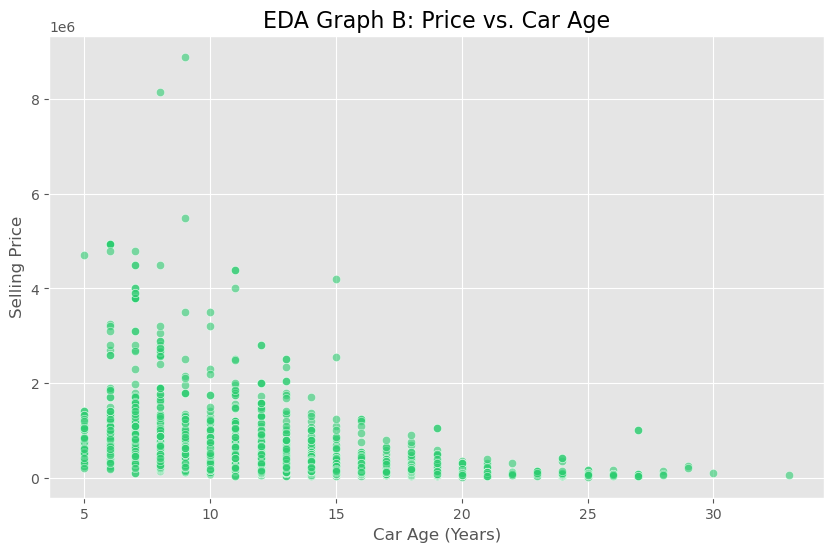

In [148]:
# Graph B: Price vs. Age (Depreciation)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Car_Age', y='selling_price', data=df, alpha=0.6, color='#2ecc71')
plt.title('EDA Graph B: Price vs. Car Age', fontsize=16)
plt.xlabel('Car Age (Years)')
plt.ylabel('Selling Price')
plt.show()

In [149]:
# --- VIF Check for Multicollinearity ---
X_vif = df[['km_driven', 'Car_Age']]
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("\n--- Multicollinearity Check (VIF) ---")
print(vif_data)


--- Multicollinearity Check (VIF) ---
     feature       VIF
0  km_driven  3.633601
1    Car_Age  3.633601


In [150]:
# Define Targets and Features
y_log = df['Selling_Price_Log'] 
y_original = df['selling_price']
X = df.drop(['selling_price', 'Selling_Price_Log'], axis=1)

numerical_features = ['km_driven', 'Car_Age']
categorical_features = ['fuel', 'seller_type', 'transmission', 'owner', 'Car_Brand']

In [151]:
# Encoding Categorical Features (One-Hot)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_encoded = encoder.fit_transform(X[categorical_features])
feature_names = list(encoder.get_feature_names_out(categorical_features))
X_cat_df = pd.DataFrame(X_cat_encoded, columns=feature_names, index=X.index)

In [152]:
# Scaling Numerical Features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X[numerical_features])
X_num_df = pd.DataFrame(X_num_scaled, columns=numerical_features, index=X.index)

In [153]:
# Final Feature Matrix
X_final = pd.concat([X_num_df, X_cat_df], axis=1)

# Split Data (80/20 split)
X_train, X_test, y_log_train, y_log_test, y_orig_train, y_orig_test = train_test_split(
    X_final, y_log, y_original, test_size=0.2, random_state=42
)

In [154]:
# --- Model 1: Multiple Linear Regression (Baseline) ---
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_log_train)
y_mlr_pred = np.expm1(mlr_model.predict(X_test))
y_test_original = np.expm1(y_log_test)

In [155]:
# --- Model 2: Random Forest Regressor (High Performance) ---
rf_model = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_orig_train)
y_rf_pred = rf_model.predict(X_test)

In [156]:
# --- Model 3: Gradient Boosting Regressor (Advanced/Optimized) ---
param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.05]}
gbr_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_orig_train)
best_gbr = grid_search.best_estimator_
y_gbr_pred = best_gbr.predict(X_test)

In [157]:
# --- Metric Calculation ---
def calculate_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

mlr_metrics = calculate_metrics(y_test_original, y_mlr_pred)
rf_metrics = calculate_metrics(y_orig_test, y_rf_pred)
gbr_metrics = calculate_metrics(y_orig_test, y_gbr_pred)

In [158]:
# --- Summary Table ---
performance_data = {
    'Model': ['MLR Baseline', 'Random Forest', 'Gradient Boosting (Optimized)'],
    'R²': [mlr_metrics['R2'], rf_metrics['R2'], gbr_metrics['R2']],
    'MAE': [mlr_metrics['MAE'], rf_metrics['MAE'], gbr_metrics['MAE']],
    'RMSE': [mlr_metrics['RMSE'], rf_metrics['RMSE'], gbr_metrics['RMSE']]
}
performance_df = pd.DataFrame(performance_data)
print("\n--- Final Model Performance Summary Table ---")
print(performance_df.to_markdown(index=False, floatfmt=".4f"))


--- Final Model Performance Summary Table ---
| Model                         |     R² |         MAE |        RMSE |
|:------------------------------|-------:|------------:|------------:|
| MLR Baseline                  | 0.6142 | 145189.5241 | 343102.6642 |
| Random Forest                 | 0.7548 | 120125.6368 | 273541.6846 |
| Gradient Boosting (Optimized) | 0.7124 | 135945.3503 | 296235.9825 |


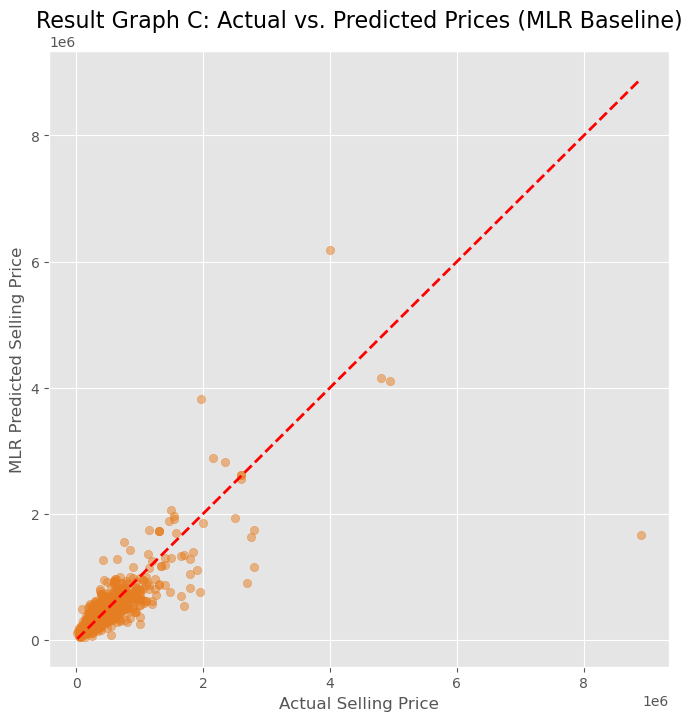

In [159]:
# Graph C (New): Actual vs. Predicted Prices (MLR Baseline Performance)
# This visually demonstrates the low R-squared performance of the baseline model.
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original, y_mlr_pred, alpha=0.5, color='#e67e22') # Orange for baseline
plt.plot([min(y_orig_test), max(y_orig_test)], [min(y_orig_test), max(y_orig_test)], 'r--', linewidth=2)
plt.title('Result Graph C: Actual vs. Predicted Prices (MLR Baseline)', fontsize=16)
plt.xlabel("Actual Selling Price", fontsize=12)
plt.ylabel("MLR Predicted Selling Price", fontsize=12)
plt.show()

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

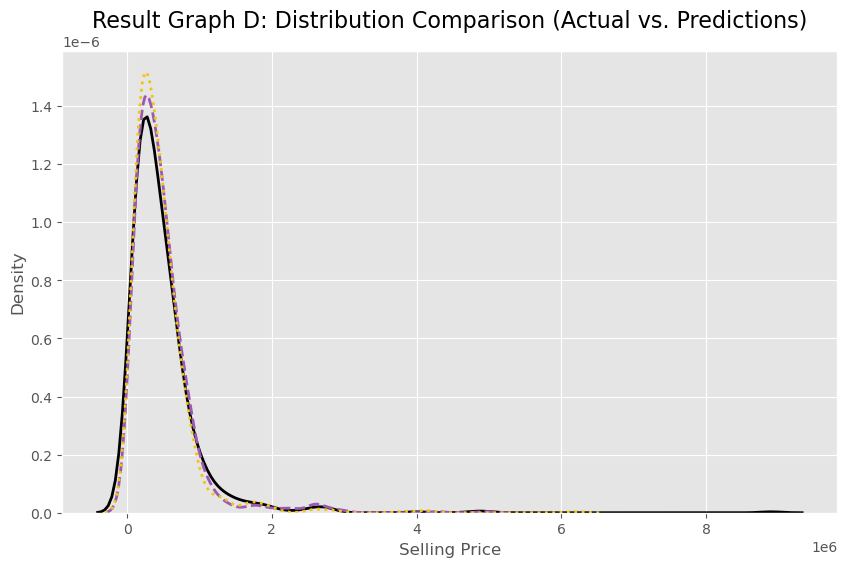

In [160]:
# Graph D (New): Prediction Distribution Comparison (Actual vs. RF)
# This visually shows which model's output distribution is closest to the real data
plt.figure(figsize=(10, 6))
sns.kdeplot(y_orig_test, label='Actual Price', color='black', linestyle='-', linewidth=2)
sns.kdeplot(y_rf_pred, label='RF Predicted Price', color='#9b59b6', linestyle='--', linewidth=2)
sns.kdeplot(y_mlr_pred, label='MLR Predicted Price', color='#f1c40f', linestyle=':', linewidth=2)
plt.title('Result Graph D: Distribution Comparison (Actual vs. Predictions)', fontsize=16)
plt.xlabel('Selling Price', fontsize=12)
plt.legend

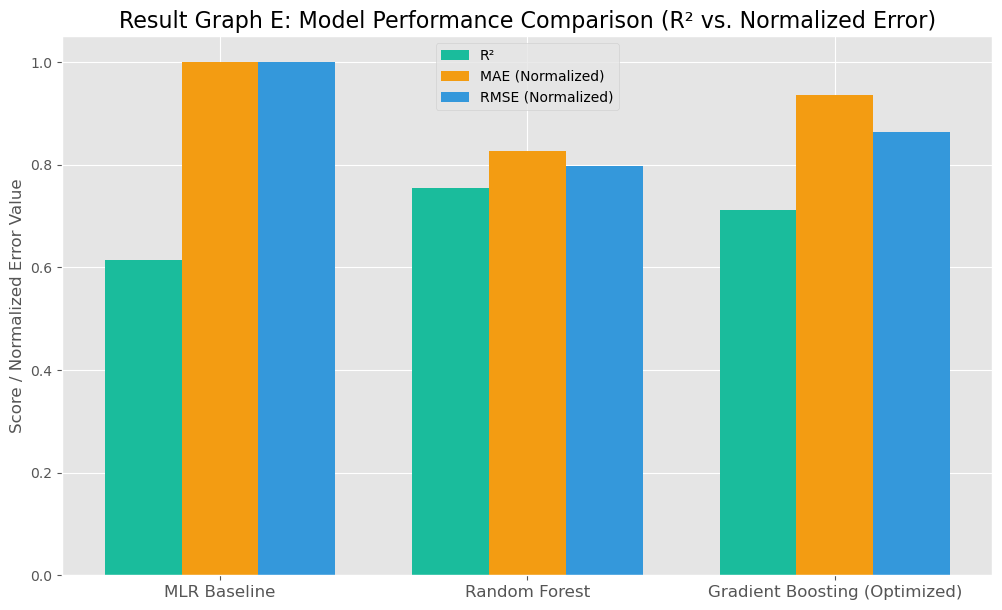

In [161]:
# Graph E: Metrics Comparison Bar Chart
x = np.arange(len(performance_df['Model']))
width = 0.25

plt.figure(figsize=(12, 7))

plt.bar(x - width, performance_df['R²'], width, label='R²', color='#1abc9c')
plt.bar(x, performance_df['MAE'] / performance_df['MAE'].max(), width, label='MAE (Normalized)', color='#f39c12')
plt.bar(x + width, performance_df['RMSE'] / performance_df['RMSE'].max(), width, label='RMSE (Normalized)', color='#3498db')

plt.title('Result Graph E: Model Performance Comparison (R² vs. Normalized Error)', fontsize=16)
plt.ylabel('Score / Normalized Error Value', fontsize=12)
plt.xticks(x, performance_df['Model'], fontsize=12)
plt.legend(fontsize=10)
plt.show()

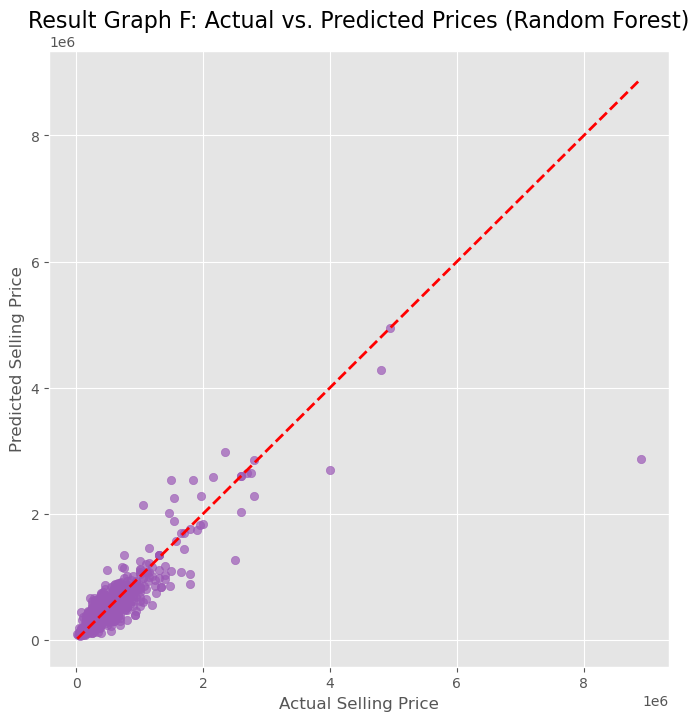

In [162]:
# Graph F: Actual vs. Predicted Prices (Best Model: Random Forest)
plt.figure(figsize=(8, 8))
plt.scatter(y_orig_test, y_rf_pred, alpha=0.7, color='#9b59b6')
plt.plot([min(y_orig_test), max(y_orig_test)], [min(y_orig_test), max(y_orig_test)], 'r--', linewidth=2)
plt.title('Result Graph F: Actual vs. Predicted Prices (Random Forest)', fontsize=16)
plt.xlabel("Actual Selling Price", fontsize=12)
plt.ylabel("Predicted Selling Price", fontsize=12)
plt.show()

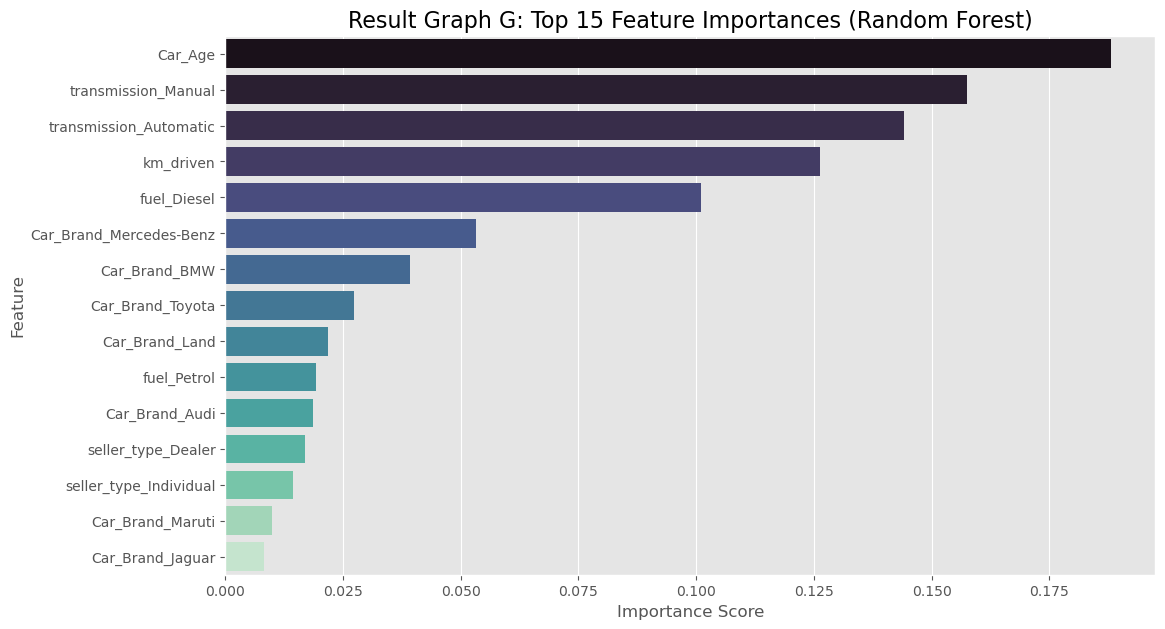

In [163]:
plt.figure(figsize=(12, 7))
sns.barplot(
    x=feature_importance_df.values,
    y=feature_importance_df.index,
    hue=feature_importance_df.index,      # <- Added
    palette="mako",
    dodge=False,                          # <- Keeps the same bar alignment
    legend=False                          # <- Removes unwanted legend
)
plt.title('Result Graph G: Top 15 Feature Importances (Random Forest)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
